In [79]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

### Helper functions

In [ ]:
def crop_and_bin(img, bin_size, min_h, min_w):
    """Crop image to dimensions divisible by bin_size, then bin by averaging"""
    crop_h = (min_h // bin_size) * bin_size
    crop_w = (min_w // bin_size) * bin_size
    img = img[:crop_h, :crop_w]
    binned = img.reshape(
        crop_h // bin_size, bin_size,
        crop_w // bin_size, bin_size
    ).mean(axis=(1, 3))
    return binned

def load_and_process_images(parent_dir, bin_size=10, crop_size=1307):
    """Load all mCherry images from directory, flip left images, crop and bin. Return average image. 
    Note: no transformations applied, similar positions assumed"""
    binned_images = []
    folders = [f for f in os.listdir(parent_dir) if not f.startswith('.')]
    
    for cage_folder in folders:
        cage_path = os.path.join(parent_dir, cage_folder, 'MeA')
        mouse_folders = [f for f in os.listdir(cage_path) if os.path.isdir(os.path.join(cage_path, f))]

        for mouse_folder in mouse_folders:
            mouse_path = os.path.join(cage_path, mouse_folder)
            mCherry_files = sorted([f for f in os.listdir(mouse_path) if f.endswith("mCherry.tif")])
            
            for file in mCherry_files:
                image_stack = tiff.imread(os.path.join(mouse_path, file))
                max_proj = np.max(image_stack, axis=0)
                if "left" in file: # Only displaying right amygdala, all left images are flipped along the vertical axis
                    max_proj = np.fliplr(max_proj)
                binned = crop_and_bin(max_proj, bin_size, crop_size, crop_size)
                binned_images.append(binned)

    binned_stack = np.stack(binned_images)
    avg_image = np.mean(binned_stack, axis=0)
    h, w = avg_image.shape
    avg_image = avg_image[:, :int(w * 0.6)]  # Keep left 60%
    return avg_image

def plot_signal_distributions(avg_image, pixel_size_um=1.657): # For other images, adjust how many micrometers each pixel represents
    """Plot average image and corresponding x/y intensity histograms"""
    # Convert pixel dimensions to micrometers
    x_um = np.arange(avg_image.shape[1]) * pixel_size_um
    y_um = np.arange(avg_image.shape[0]) * pixel_size_um
    intensity_x = np.sum(avg_image, axis=0)
    intensity_y = np.sum(avg_image, axis=1)

    # Custom colormap: red signal on black background
    black_red = LinearSegmentedColormap.from_list('black_red', ['black', 'red'])

    fig = plt.figure(figsize=(13, 13))
    gs = GridSpec(4, 5, figure=fig, wspace=0.001, hspace=0.2, width_ratios=[0.5, 0.05, 1, 1, 0.05])

    # Top: x-axis histogram
    ax_top = fig.add_subplot(gs[0, 2:4])
    ax_top.bar(x_um, intensity_x, color='silver', edgecolor='grey', width=pixel_size_um)
    ax_top.set_xlim([x_um[0], x_um[-1]])
    ax_top.set_xticks([])
    ax_top.set_ylabel("Intensity", fontsize=10)
    ax_top.set_title("X-axis (µm)", fontsize=11)

    # Left: y-axis histogram
    ax_left = fig.add_subplot(gs[1:4, 0])
    ax_left.barh(y_um, intensity_y, color='silver', edgecolor='grey', height=pixel_size_um)
    ax_left.set_ylim([y_um[-1], y_um[0]])  # Flip to match image orientation
    ax_left.set_yticks([])
    ax_left.set_xlabel("Intensity", fontsize=10)
    ax_left.set_title("Y-axis (µm)", fontsize=11)

    # Center: Average intensity image
    ax_img = fig.add_subplot(gs[1:4, 2:4])
    ax_img.imshow(avg_image, cmap=black_red)
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_img.set_title("Average Signal", fontsize=12)

    plt.show()

### Signal distribution plotting

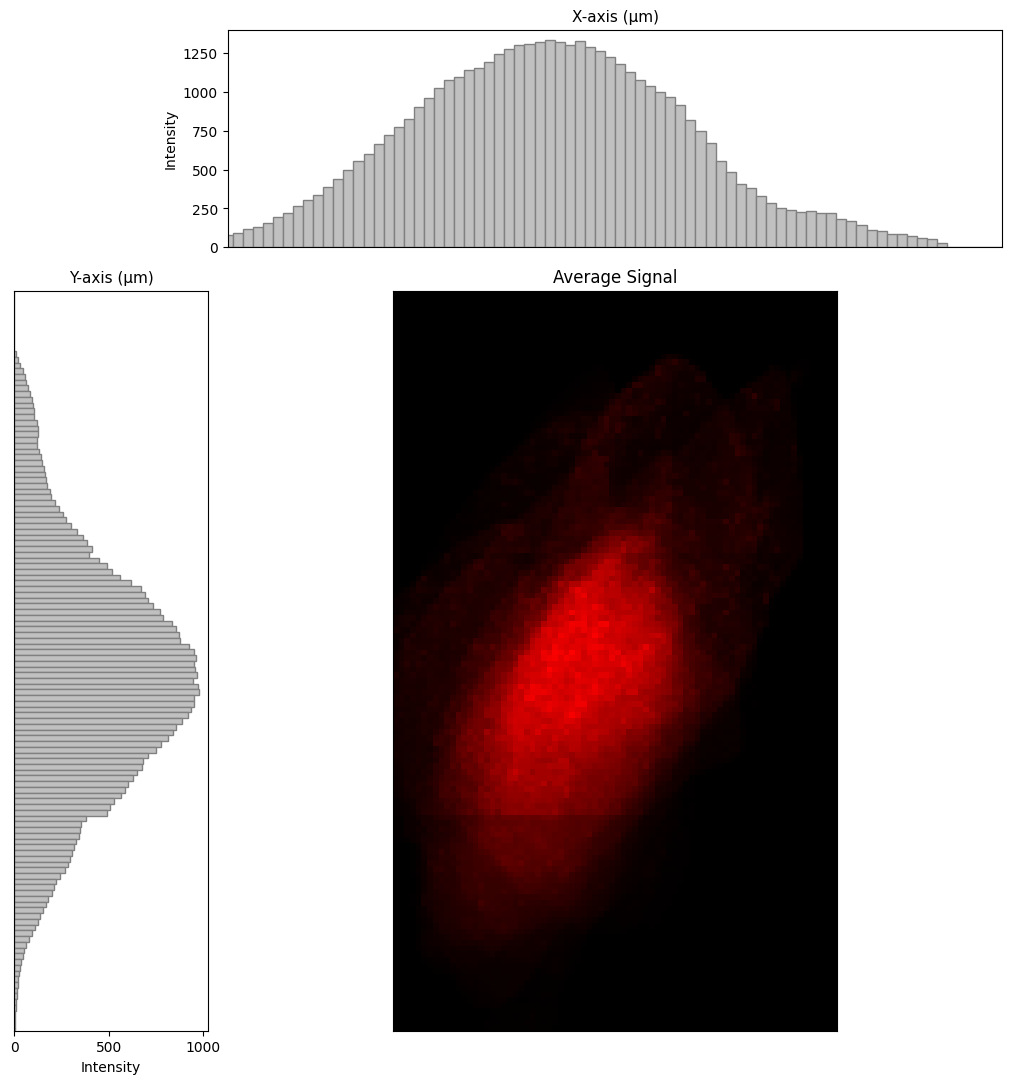

In [85]:
parent_dir = '/Users/neur1s/Library/CloudStorage/OneDrive-UniversityofToronto/Desktop/SM/data/Engram_hm4d_inhibition_aversive_022025/data'
avg_image = load_and_process_images(parent_dir)
plot_signal_distributions(avg_image)